# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import boto3
from sklearn.preprocessing import LabelEncoder
from io import BytesIO
from botocore.exceptions import NoCredentialsError, ClientError
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

# This package will help ignore warning message
warnings.filterwarnings('ignore')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Read CSV from S3 bucket

In [2]:
def read_csv_from_s3_as_df(bucket, key):
    try:
        # Create an S3 client
        s3 = boto3.client('s3')

        # Get the object from S3
        obj = s3.get_object(Bucket=bucket, Key=key)

        # Read the contents of the file into a pandas DataFrame
        df_pre_clean = pd.read_csv(BytesIO(obj['Body'].read()))

        return df_pre_clean
    except NoCredentialsError:
        print("Credentials not available")
    except ClientError as e:
        print(f"An error occurred: {e}")
    except Exception as e:
        print(f"An error occurred during DataFrame conversion: {e}")

bucket = 'big-data-rmit-asm3'  
key = 'cleaned_data/completed_dataset.csv'  
df = read_csv_from_s3_as_df(bucket, key)
if df is not None:
    print(df)
else:
    print("No data returned or error occurred")

             City    Weather_Timestamp  Temperature(K)  Humidity(%)  \
0       Charlotte  2022-09-08 05:54:00      294.261111         81.0   
1       Charlotte  2022-09-08 06:34:00      293.705556         84.0   
2       Charlotte  2022-09-08 06:34:00      293.705556         84.0   
3       Charlotte  2022-09-08 06:34:00      293.705556         84.0   
4          Dallas  2022-09-08 04:53:00      298.150000         82.0   
...           ...                  ...             ...          ...   
868836  Charlotte  2017-11-29 20:00:00      294.150000         21.0   
868837  Charlotte  2017-11-29 21:00:00      293.900000         21.0   
868838  Charlotte  2017-11-29 22:00:00      292.060000         24.0   
868839  Charlotte  2017-11-29 23:00:00      287.580000         38.0   
868840  Charlotte  2017-11-30 00:00:00      285.610000         41.0   

        Pressure(hPa)  Wind_Speed(m/s) Weather_Condition Weather_Group  
0          987.809671          4.02336            Cloudy        Cloudy  
1

In [3]:
df.drop('Weather_Condition', axis=1, inplace= True)

In [4]:
#Basic mapping of column names to shorten length for easier use
columns_mapping = {"Temperature(K)" : "Temp", "Humidity(%)" : "Humidity", "Pressure(hPa)": "Pressure", "Wind_Speed(m/s)" : "Wind_speed", "Weather_Timestamp" : "Time" }
df.rename(columns=columns_mapping, inplace=True)

In [5]:
# #Changing time to integer for usage
df["Time"] = pd.to_datetime(df["Time"])
df.set_index("Time", inplace=True)

# Basic data exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 868841 entries, 2022-09-08 05:54:00 to 2017-11-30 00:00:00
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   City           868841 non-null  object 
 1   Temp           867943 non-null  float64
 2   Humidity       867301 non-null  float64
 3   Pressure       868315 non-null  float64
 4   Wind_speed     841054 non-null  float64
 5   Weather_Group  868841 non-null  object 
dtypes: float64(4), object(2)
memory usage: 46.4+ MB


In [7]:
df.describe()

,Temp,Humidity,Pressure,Wind_speed
count,867943.000000,867301.000000,868315.000000,841054.000000
mean,290.729482,65.924757,1008.589065,3.222298
std,9.691936,20.892937,13.928973,2.241074
min,239.261111,1.000000,9.820528,0.000000
25%,285.372222,51.000000,998.307477,1.564640
50%,291.620000,68.000000,1011.853033,3.000000
75%,297.594444,83.000000,1017.609894,4.470400
max,349.150000,100.000000,1948.528231,113.995200


## Cleaning null data

In [8]:
# show percentage of null data in each column
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

City             0.00
Temp             0.10
Humidity         0.18
Pressure         0.06
Wind_speed       3.20
Weather_Group    0.00
dtype: float64

In [9]:
df = df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 839927 entries, 2022-09-08 05:54:00 to 2017-11-30 00:00:00
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   City           839927 non-null  object 
 1   Temp           839927 non-null  float64
 2   Humidity       839927 non-null  float64
 3   Pressure       839927 non-null  float64
 4   Wind_speed     839927 non-null  float64
 5   Weather_Group  839927 non-null  object 
dtypes: float64(4), object(2)
memory usage: 44.9+ MB


## Check duplicated rows

In [11]:
#drop duplicated rows, keep the first occurrence of each unique row
df = df.drop_duplicates()

In [12]:
df.shape

(529655, 6)

In [13]:
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
    print(f'Duplicate rows found:\n{duplicate_rows}')
else:
    print('No duplicate rows found.')

No duplicate rows found.


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 529655 entries, 2022-09-08 05:54:00 to 2017-11-30 00:00:00
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   City           529655 non-null  object 
 1   Temp           529655 non-null  float64
 2   Humidity       529655 non-null  float64
 3   Pressure       529655 non-null  float64
 4   Wind_speed     529655 non-null  float64
 5   Weather_Group  529655 non-null  object 
dtypes: float64(4), object(2)
memory usage: 28.3+ MB


## Check unique values

In [15]:
df['Weather_Group'].unique()

array(['Cloudy', 'Fair', 'Rain', 'Thunderstorm', 'Fog', 'Drizzle',
       'Clear', 'Overcast'], dtype=object)

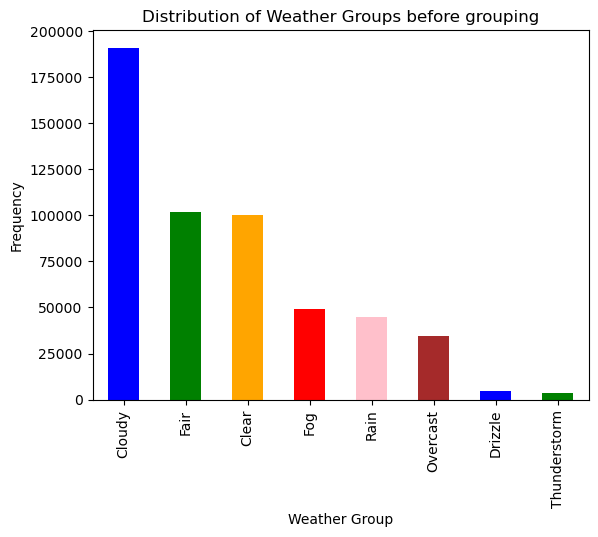

In [16]:
df['Weather_Group'].value_counts().plot(kind='bar', color=['blue', 'green', 'orange', 'red', 'pink', 'brown'])
plt.title('Distribution of Weather Groups before grouping')
plt.xlabel('Weather Group')
plt.ylabel('Frequency')
plt.show()

As the Cloudy and Overcast is relatively the same, it will be grouped into one named "Cloudy" in order to simplify the classification problem. The same solution will be applied to Rain, Drizzle and Thunderstorm, which make them become "Rain" group.

In [17]:
df.loc[(df['Weather_Group'] == 'Rain') | (df['Weather_Group'] == 'Drizzle') | (df['Weather_Group'] == 'Thunderstorm'), 'Weather_Group'] = 'Rain'
df.loc[(df['Weather_Group'] == 'Overcast') | (df['Weather_Group'] == 'Cloudy'), 'Weather_Group'] = 'Cloudy'
df.loc[(df['Weather_Group']=='Fair') | (df['Weather_Group']=='Clear'), 'Weather_Group'] = 'Clear'

In [18]:
df['Weather_Group'].unique()

array(['Cloudy', 'Clear', 'Rain', 'Fog'], dtype=object)

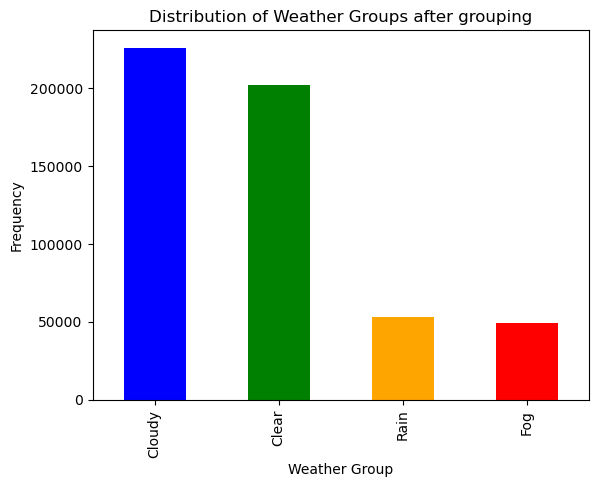

In [19]:
df['Weather_Group'].value_counts().plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.title('Distribution of Weather Groups after grouping')
plt.xlabel('Weather Group')
plt.ylabel('Frequency')
plt.show()

Based on the bar graph, the dataset can be quite imbalanced as there are many cloudy values which nearly doubled other groups.

***Possible options to choose***
- Resampling(Undersampling/Oversampling)
- Loss function
- Evaluation metric that are sensitive to imbalanced dataset(Precision/Recall/F1 score, ROC curve)

## Check data distribution

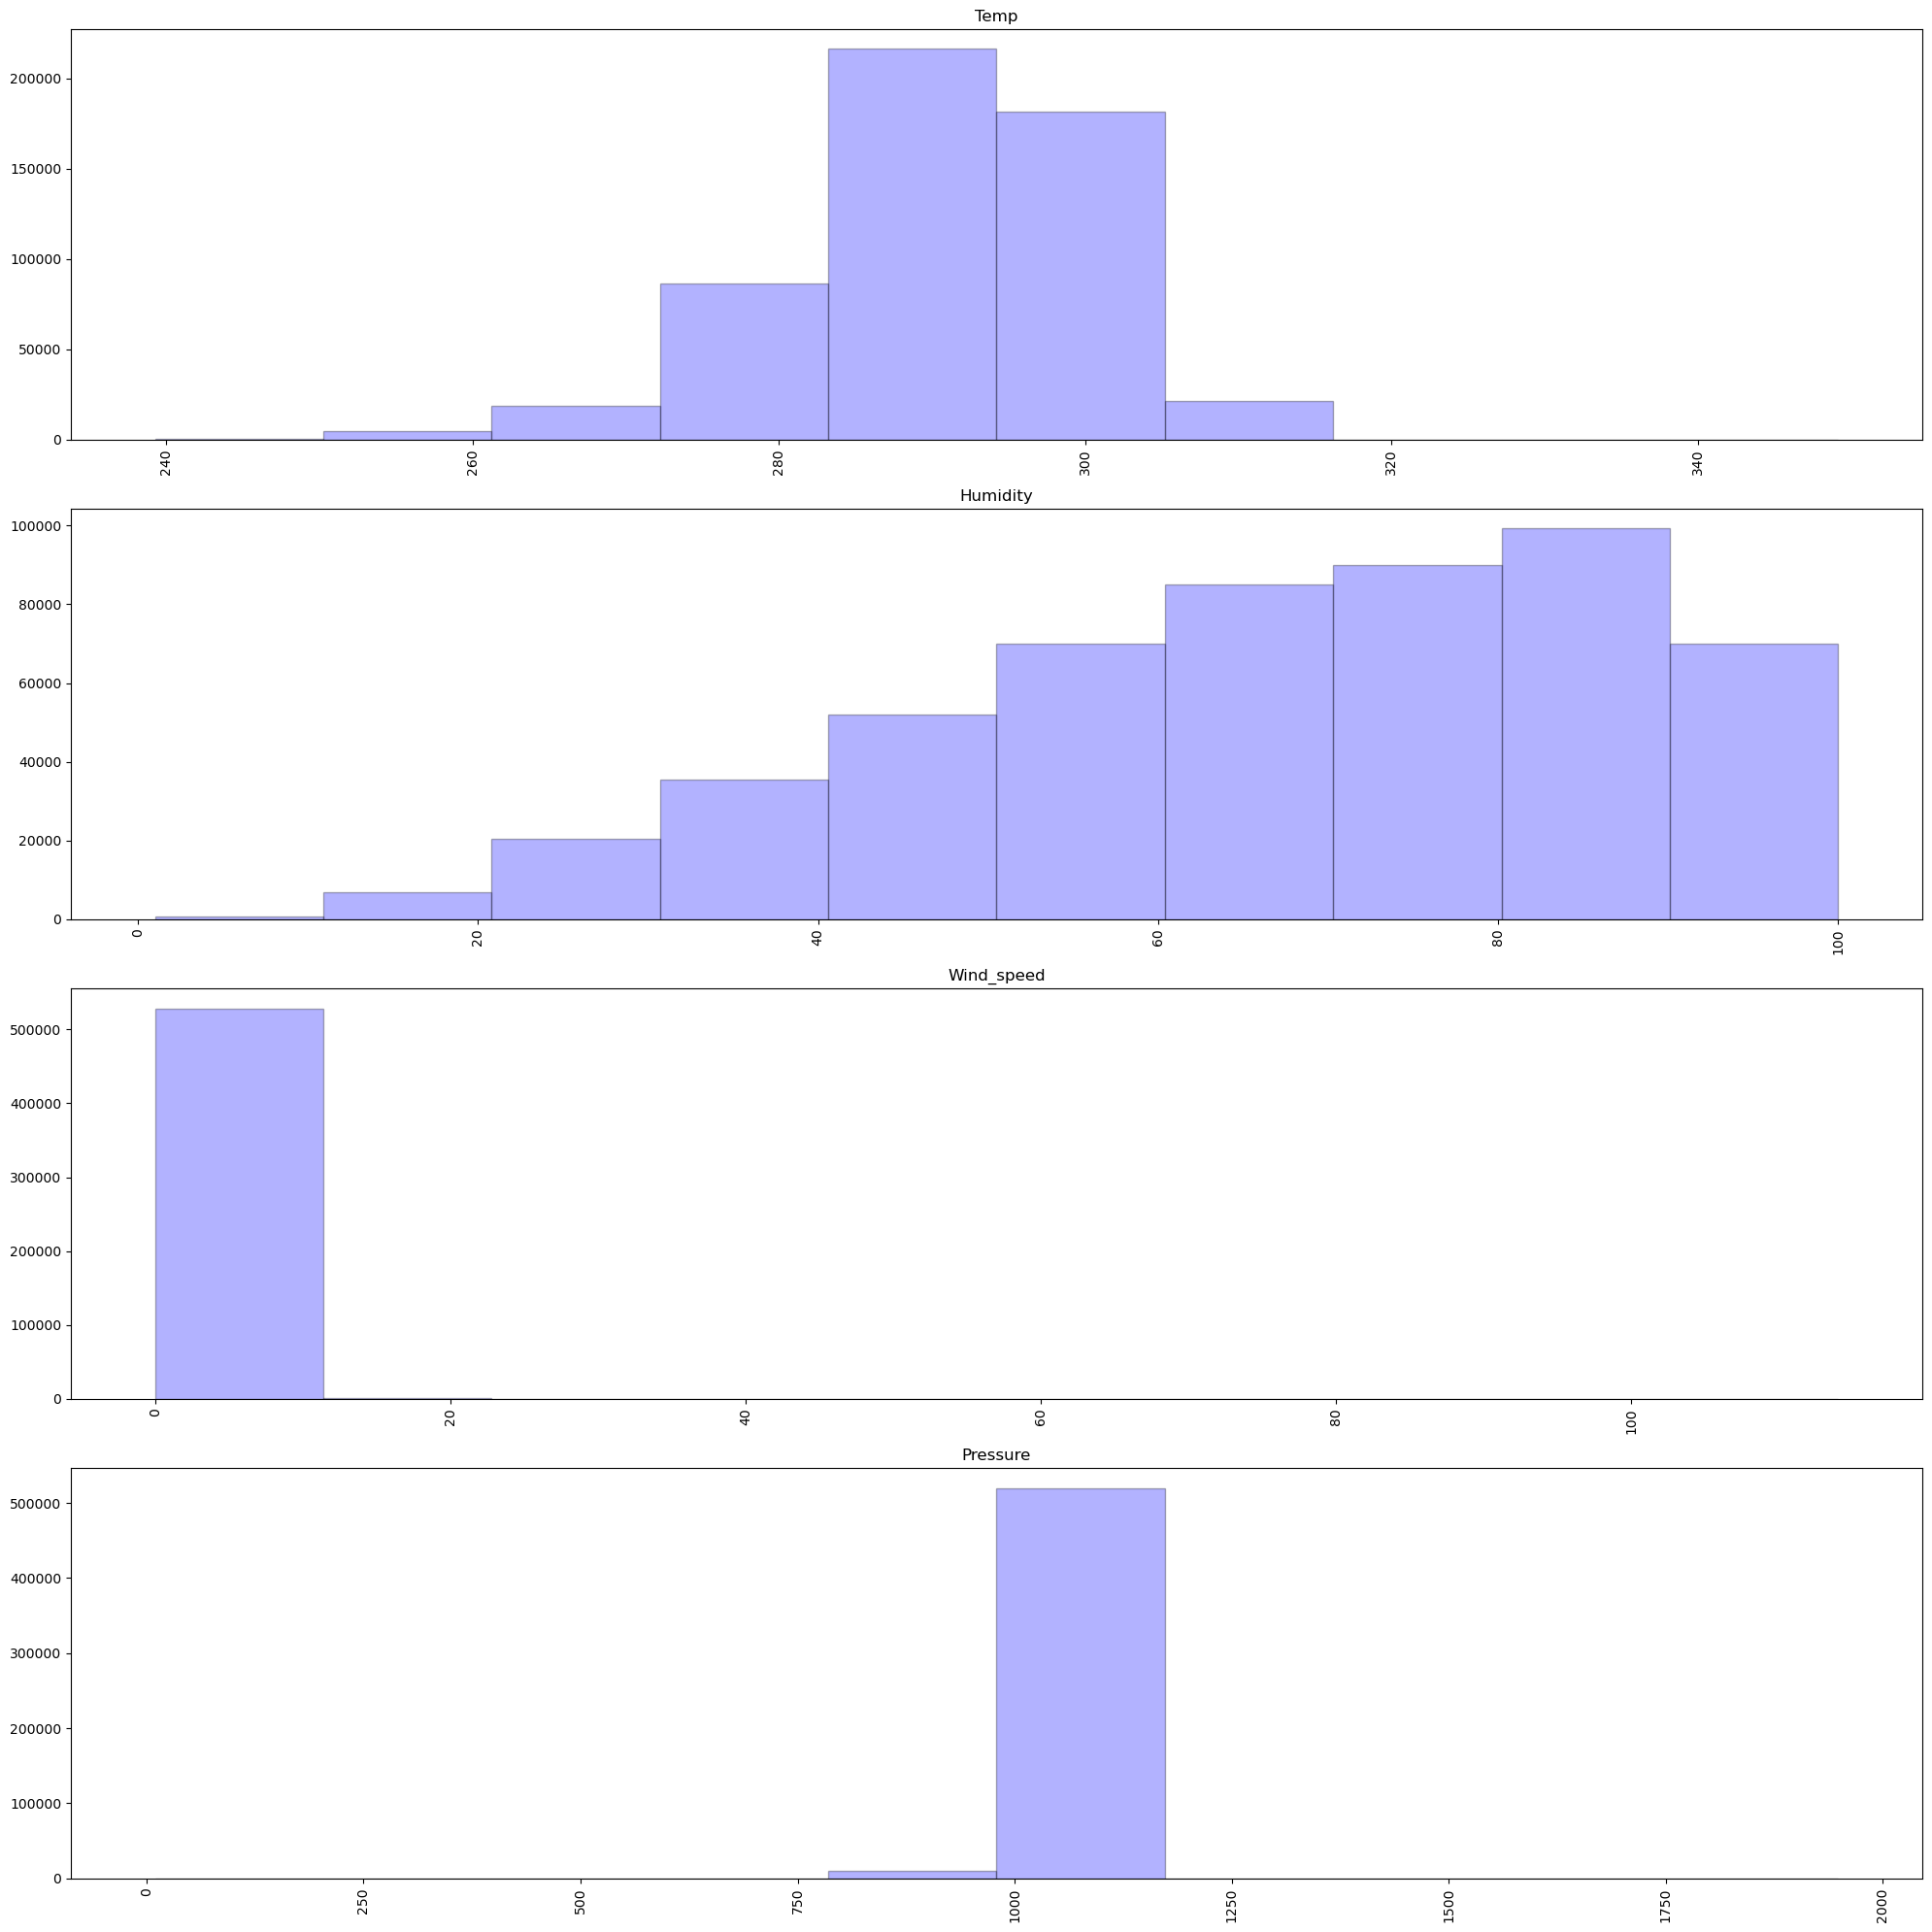

In [20]:
plt.figure(figsize=(20, 20))
columns = ['Temp', 'Humidity', 'Wind_speed', 'Pressure']

# Plot all columns in the dataset
for i, col in enumerate(columns):
    plt.subplot(4, 1, i + 1)
    plt.hist(df[col], alpha=0.3, color='b', edgecolor="black", density=False)  
    plt.title(col)
    plt.xticks(rotation='vertical')

plt.tight_layout() 
plt.show()


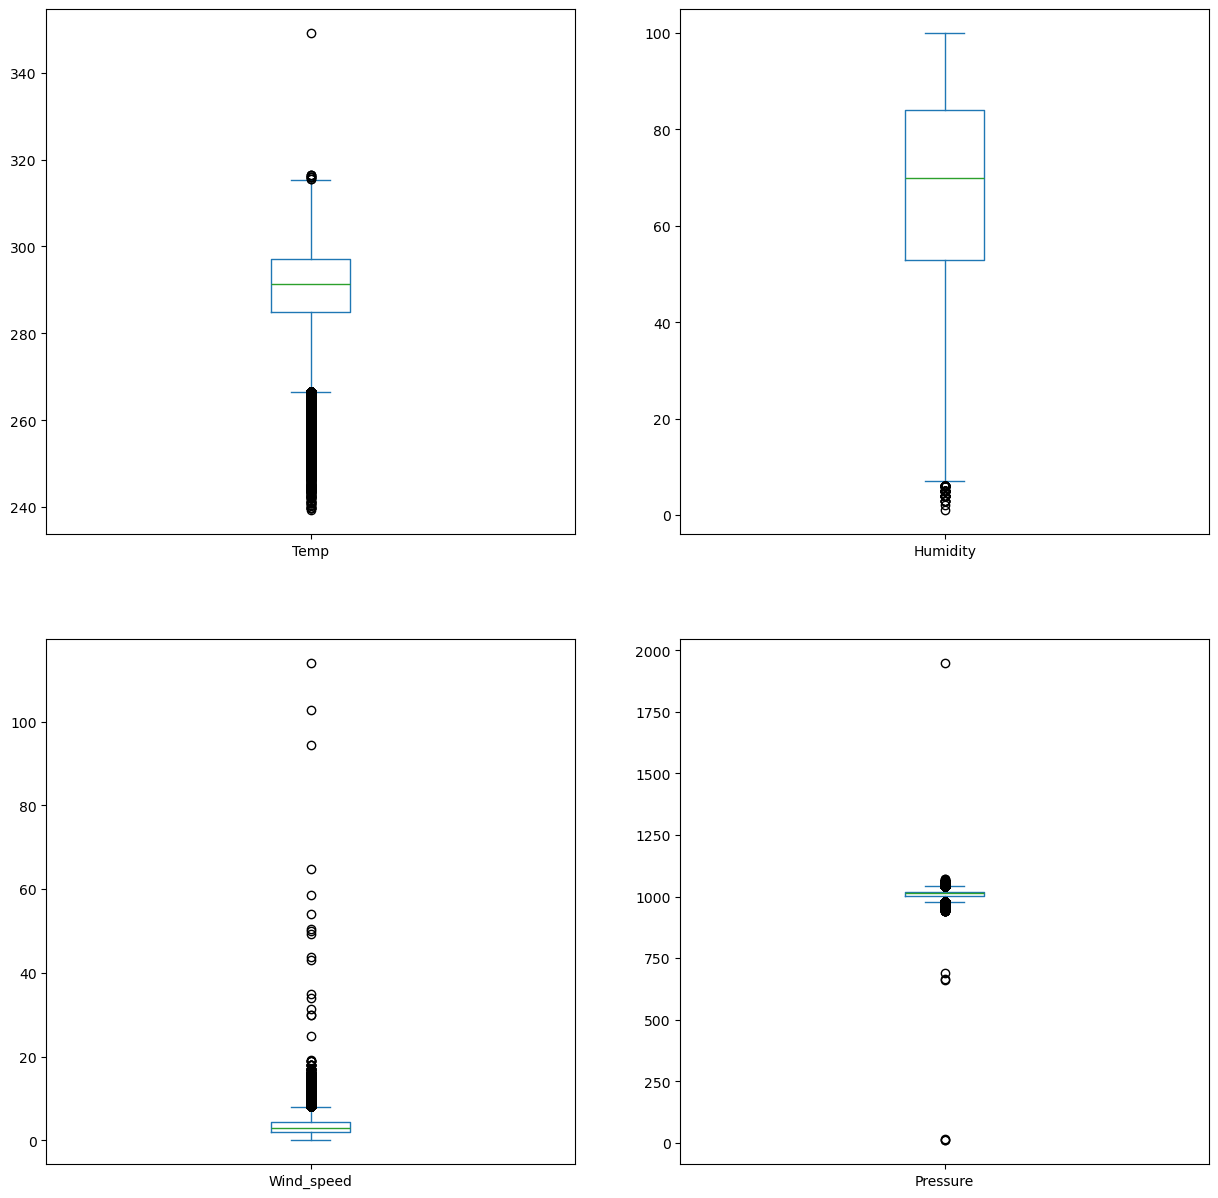

In [21]:
df[columns].plot(kind = 'box', subplots = True, layout = (2,2), figsize = (15, 15), sharex = False,sharey = False)
plt.show()

In the box plot, there are many black dots. However, in this scenario, we won't consider it as outliers since the data in quartile represent the majorities of the dataset while black dots represent the minorities, so they are not outliers

## Check numerical variable's relationship

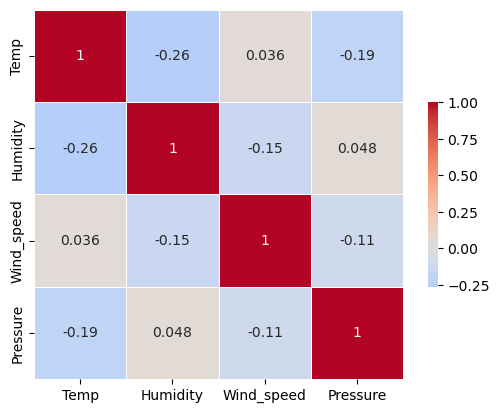

In [22]:
corr = df[columns].corr()

sns.heatmap(corr, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

## Feature selection

In [23]:
#Label encoding cities
le1 = LabelEncoder()
le2 = LabelEncoder()
df['City'] = le1.fit_transform(df['City'])
df['Weather_Group']= le2.fit_transform(df['Weather_Group'])

In [24]:
# Create dictionaries to map original values to encoded values for each column
city_mapping = dict(zip(le1.classes_, le1.transform(le1.classes_)))
weather_group_mapping = dict(zip(le2.classes_, le2.transform(le2.classes_)))

# Print the pairs of original values and their encoded values for each column
print("City Mapping:")
for original_value, encoded_value in city_mapping.items():
    print(f"Original Value: {original_value} => Encoded Value: {encoded_value}")

print("\nWeather Group Mapping:")
for original_value, encoded_value in weather_group_mapping.items():
    print(f"Original Value: {original_value} => Encoded Value: {encoded_value}")

City Mapping:
Original Value: Charlotte => Encoded Value: 0
Original Value: Chicago => Encoded Value: 1
Original Value: Dallas => Encoded Value: 2
Original Value: Houston => Encoded Value: 3
Original Value: Indianapolis => Encoded Value: 4
Original Value: Los Angeles => Encoded Value: 5
Original Value: Minneapolis => Encoded Value: 6
Original Value: San Antonio => Encoded Value: 7
Original Value: San Diego => Encoded Value: 8
Original Value: San Francisco => Encoded Value: 9

Weather Group Mapping:
Original Value: Clear => Encoded Value: 0
Original Value: Cloudy => Encoded Value: 1
Original Value: Fog => Encoded Value: 2
Original Value: Rain => Encoded Value: 3


In [25]:
df['month'] = df.index.month
df['date'] = df.index.day
df['hour'] = df.index.hour

### Check correlation

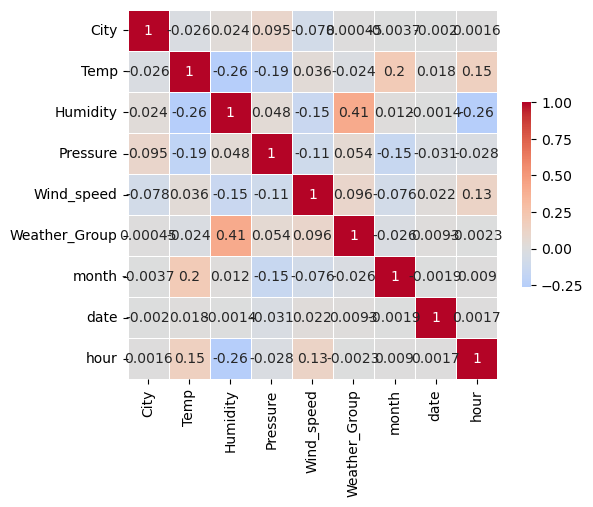

In [26]:
corr = df.corr()

sns.heatmap(corr, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Feature importance ranking using tree-based model

In [27]:
!pip install imblearn

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
# Separate features (X) and target (y)
X = df.drop('Weather_Group', axis=1)
y = df['Weather_Group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and fit the SMOTE resampler on the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

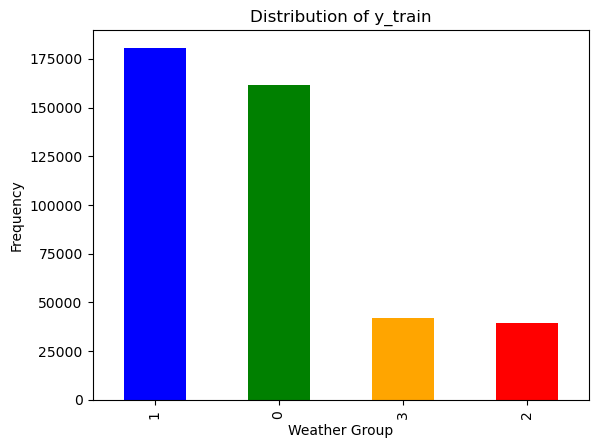

In [29]:
y_train.value_counts().plot(kind='bar', color=['blue', 'green', 'orange', 'red', 'pink', 'brown'])
plt.title('Distribution of y_train')
plt.xlabel('Weather Group')
plt.ylabel('Frequency')
plt.show()

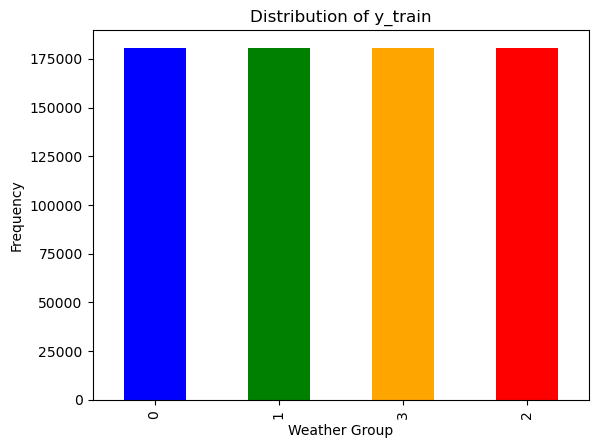

In [30]:
y_resampled.value_counts().plot(kind='bar', color=['blue', 'green', 'orange', 'red', 'pink', 'brown'])
plt.title('Distribution of y_train')
plt.xlabel('Weather Group')
plt.ylabel('Frequency')
plt.show()

#### Default model with SMOTE

In [38]:
# Train a Random forest classifier on the resampled data
clf_1 = RandomForestClassifier()
clf_1.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_1 = clf_1.predict(X_test)

# Evaluate the classifier's performance 
report_1 = classification_report(y_test, y_pred_1)
print(report_1)

              precision    recall  f1-score   support

           0       0.69      0.76      0.72     33734
           1       0.71      0.67      0.69     61073
           2       0.69      0.70      0.69     36012
           3       0.60      0.60      0.60     15412

    accuracy                           0.69    146231
   macro avg       0.67      0.68      0.68    146231
weighted avg       0.69      0.69      0.69    146231



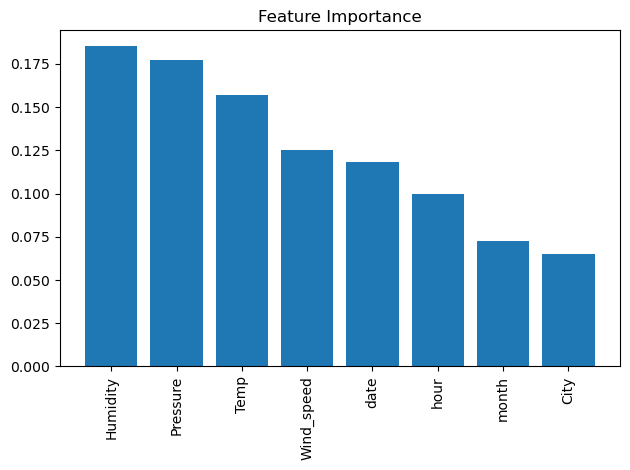

In [39]:
# Get feature importances
importances = clf_1.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Visualize the feature importances
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### Conclusion
According to the correlation heatmap and the feature ranking, there is no feature which is highly important compared to others. To be more specific, from the heatmap, there is no positive or negative linear relationship found so none of them will be removed. Whereas in the ranking, Temp column is the most important feature with the score at nearly 0.35 compared to the lowest being City column. However, the overall score is relatively identical which means that there is no outstanding feature. As a result, all of them will be used as training data for data modeling.

### Upload transformed dataset after feature engineering

In [183]:
import io
import boto3
import os
bucket = 'big-data-rmit-asm3'
prefix = 'train-test-data/'

s3_resource = boto3.Session().resource('s3')

# Create a function to upload dataframe to S3 bucket
def upload_s3_csv(filename, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=True, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, filename)).put(Body=csv_buffer.getvalue())

file_4 = 'weather_dataset.csv'
upload_s3_csv(file_4, df)

## Data modelling

In [31]:
bucket = 'big-data-rmit-asm3'  # bucket name
key1 = 'train-test-data/weather_dataset.csv'# path to your CSV file

weather_dataset = read_csv_from_s3_as_df(bucket, key1)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
X = weather_dataset.drop('Weather_Group', axis=1)
y = weather_dataset['Weather_Group']
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.2, random_state=42, stratify=y_test_val)

# Initialize and fit the SMOTE resampler on the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### RandomForest

In [52]:
# Initialize the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_test)
f1_test = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1_test:.2f}")

F1 Score: 0.69


In [33]:
# Define a custom function to apply SMOTE and train in each fold
def cross_val_with_smote(estimator, X, y, cv):
    f1_scores_test = []

    for train_index, test_index in cv.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        # Train the model
        estimator.fit(X_train_resampled, y_train_resampled)

        # Evaluate the model on the test set
        y_test_pred = estimator.predict(X_test_fold)
        f1_test = f1_score(y_test_fold, y_test_pred, average='weighted')
        f1_scores_test.append(f1_test)

    return np.mean(f1_scores_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Initialize the cross-validator
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation with SMOTE
average_f1_score_test = cross_val_with_smote(rf, X, y, skf)

print(f"F1 Score: {average_f1_score_test}")

F1 Score: 0.6819694786431603


In [34]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 120],
    'max_depth' : [40,50],
    'max_features': ['sqrt'],
}
rf = RandomForestClassifier(random_state=42)

rf_gs = GridSearchCV(estimator = rf, param_grid=params, scoring='f1_weighted', cv=2, n_jobs=-1)

rf_gs.fit(X_resampled, y_resampled)

print(rf_gs.best_score_)
print(rf_gs.best_estimator_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of

0.7772471513357192
RandomForestClassifier(max_depth=40, n_estimators=120, random_state=42)


In [38]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np


# Initialize the model
rf2 = RandomForestClassifier(max_depth=40, n_estimators= 120)

# Initialize the cross-validator
skf2 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation with SMOTE
average_f1_score_test_2 = cross_val_with_smote(rf2, X, y, skf2)

print(f"F1 Score: {average_f1_score_test_2}")


F1 Score: 0.6829478160350527


### Extra Trees

In [33]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score

et = ExtraTreesClassifier()

et.fit(X_resampled, y_resampled)
y_pred = et.predict(X_test)
f1_test = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1_test:.2f}")

F1 Score: 0.71


In [36]:
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Initialize the model
et = ExtraTreesClassifier()

# Initialize the cross-validator
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation with SMOTE
et_average_f1_score_test = cross_val_with_smote(et, X, y, skf)

print(f"F1 Score: {et_average_f1_score_test}")

F1 Score: 0.6992825511353343


In [195]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 120],
    'max_depth' : [50,70],
}
et = ExtraTreesClassifier(random_state=42)

et_gs = GridSearchCV(estimator = et, param_grid=params, scoring='f1_weighted', cv=2, n_jobs=-1)

et_gs.fit(X_resampled, y_resampled)

print(et_gs.best_score_)
print(et_gs.best_estimator_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


0.793188991543903
ExtraTreesClassifier(max_depth=70, n_estimators=120, random_state=42)


In [37]:
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Initialize the model
et2 = ExtraTreesClassifier(max_depth=70, n_estimators=120)

# Initialize the cross-validator
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation with SMOTE
et_average_f1_score_test_2 = cross_val_with_smote(et2, X, y, skf)

print(f"F1 Score: {et_average_f1_score_test_2}")

F1 Score: 0.7007130567032114


### Predict unseen data

In [33]:
from sklearn.ensemble import ExtraTreesClassifier

et_final = ExtraTreesClassifier(max_depth=70, n_estimators=120, random_state=42)

## Import streaming data

In [34]:
bucket = 'big-data-rmit-asm3'
key = 'streaming-data/streaming_data.csv'
df_streaming = read_csv_from_s3_as_df(bucket, key)

In [35]:
df_streaming["City_name"] = df_streaming["City"]

### Build pipeline to clean test data

In [36]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline

# Custom transformer for dropping a column
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.column, axis=1)

# Custom transformer for renaming columns
class ColumnRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_mapping):
        self.columns_mapping = columns_mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.rename(columns=self.columns_mapping)

# Custom transformer for converting to datetime and setting index
class DateTimeIndexSetter(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_column):
        self.datetime_column = datetime_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.datetime_column] = pd.to_datetime(X[self.datetime_column])
        X.set_index(self.datetime_column, inplace=True)
        return X

# Function for label encoding a column
def label_encode_column(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    return df

class TimeFeaturesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['month'] = X.index.month
        X['date'] = X.index.day
        X['hour'] = X.index.hour
        return X


pipeline = Pipeline([
    ('drop_weather_condition', ColumnDropper('Weather Description')),
    ('rename_columns', ColumnRenamer({
        "Temperature": "Temp", "Humidity": "Humidity", 
        "Pressure": "Pressure", "Wind Speed": "Wind_speed", 
        "DateTime": "Time"
    })),
    ('set_datetime_index', DateTimeIndexSetter('Time')),
    ('drop_na', FunctionTransformer(pd.DataFrame.dropna, validate=False)),
    ('drop_duplicates', FunctionTransformer(pd.DataFrame.drop_duplicates, validate=False)),
    ('encode_city', FunctionTransformer(label_encode_column, kw_args={'column': 'City'}, validate=False)),
    ('add_time_features', TimeFeaturesAdder()),
])

In [37]:
df_transformed = pipeline.fit_transform(df_streaming)

In [38]:
df_transformed

,City,Temp,Pressure,Humidity,Wind_speed,City_name,month,date,hour
Time,,,,,,,,,
2024-01-13 10:00:00,8,282.00,1019,67,0.38,San Diego,1,13,10
2024-01-13 11:00:00,8,281.04,1019,70,0.54,San Diego,1,13,11
2024-01-13 12:00:00,8,281.93,1019,67,0.95,San Diego,1,13,12
2024-01-13 13:00:00,8,282.76,1019,64,1.59,San Diego,1,13,13
2024-01-13 14:00:00,8,283.56,1018,59,1.39,San Diego,1,13,14
...,...,...,...,...,...,...,...,...,...
2024-01-16 13:00:00,0,276.99,1011,87,2.36,Charlotte,1,16,13
2024-01-16 14:00:00,0,277.83,1010,90,2.50,Charlotte,1,16,14
2024-01-16 15:00:00,0,278.80,1011,91,2.65,Charlotte,1,16,15


In [39]:
et_final.fit(X_resampled, y_resampled)

ExtraTreesClassifier(max_depth=70, n_estimators=120, random_state=42)

In [42]:
pred = et_final.predict(df_transformed[['City', 'Temp', 'Humidity', 'Pressure', 'Wind_speed', 'month', 'date','hour']])

In [44]:
df_transformed["Prediction"] = pred

In [46]:
df_transformed["Prediction"] = le2.inverse_transform(df_transformed["Prediction"])

In [47]:
df_transformed

,City,Temp,Pressure,Humidity,Wind_speed,City_name,month,date,hour,Prediction
Time,,,,,,,,,,
2024-01-13 10:00:00,8,282.00,1019,67,0.38,San Diego,1,13,10,Fog
2024-01-13 11:00:00,8,281.04,1019,70,0.54,San Diego,1,13,11,Fog
2024-01-13 12:00:00,8,281.93,1019,67,0.95,San Diego,1,13,12,Fog
2024-01-13 13:00:00,8,282.76,1019,64,1.59,San Diego,1,13,13,Fog
2024-01-13 14:00:00,8,283.56,1018,59,1.39,San Diego,1,13,14,Cloudy
...,...,...,...,...,...,...,...,...,...,...
2024-01-16 13:00:00,0,276.99,1011,87,2.36,Charlotte,1,16,13,Rain
2024-01-16 14:00:00,0,277.83,1010,90,2.50,Charlotte,1,16,14,Rain
2024-01-16 15:00:00,0,278.80,1011,91,2.65,Charlotte,1,16,15,Rain


In [ ]:
bucket = 'big-data-rmit-asm3'
prefix = 'predictions_data/'

# Create a S3 resource using boto3
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, dataframe):
    csv_buffer = io.StringIO()
    # Convert the DataFrame to CSV and save it to a buffer
    dataframe.to_csv(csv_buffer, header=True, index=False)

    # Full path for the file in the bucket
    full_file_path = os.path.join(prefix, filename)

    # Upload the CSV file to S3
    s3_resource.Bucket(bucket).Object(full_file_path).put(Body=csv_buffer.getvalue())
    
file_name = 'predictions.csv'

upload_s3_csv(file_name, df_transformed)
